# MATH 2071 Lab 10 - Iterative methods for linear systems

Matthew Ragoza

4/7/2022

In [22]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Exercise 1 - 2D uniform mesh grid

The purpose of this exercise is to construct 2D mesh grids for use in solving PDEs using finite difference methods. First, we will create a function `xy_grid(M)` that returns vectors of x and y coordinates representing a uniform 2D square grid on the domain $[0,1] \times [0,1]$ with `M` points on each side.

In [116]:
def xy_grid(M):
    N = M * M
    h = 1 / (M - 1)
    x = np.arange(N) // M * h
    y = np.arange(N) % M * h
    return x, y

xy_grid(3)

(array([0. , 0. , 0. , 0.5, 0.5, 0.5, 1. , 1. , 1. ]),
 array([0. , 0.5, 1. , 0. , 0.5, 1. , 0. , 0.5, 1. ]))

Next, we can visualize the coordinates of the mesh grids of different sizes that are returned by this function by plotting them as scatter plots.

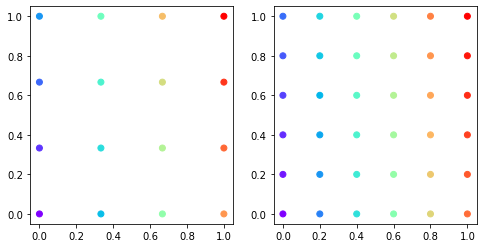

In [117]:
def exercise1():
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    for ax, M in zip(ax, [4, 6]):
        x, y = xy_grid(M)
        c = np.linspace(0, 1, M*M)
        ax.scatter(x, y, c=c, cmap='rainbow')

exercise1()

The two plots above show 2D uniform mesh grids on the interval $[0, 1] \times [0, 1]$ with different spatial resolutions. The nodes in the grid are colored according to their position in the coordinate arrays. This reveals that the nodes go from bottom to top, then left to right.

## Exercise 2 - Indexing neighor nodes

The purpose of this exercise is to create a function that returns the set of neighbors of a given node, in terms of their indices in a coordinate array. The function is implemented below and assumes that the input is a flat index into a coordinate array of a 2D uniform grid of the given size $M$.

In [110]:
def neighbors(k, M):
    assert 0 <= k < M*M
    
    # get x and y index
    i, j = divmod(k, M)
    
    n = k + 1
    if (j + 1) >= M:
        n = None

    s = k - 1
    if (j - 1) < 0:
        s = None
    
    e = k + M
    if (i + 1) >= M:
        e =  None
        
    w = k - M
    if (i - 1) < 0:
        w = None

    return n, s, e, w

neighbors(82, 11)

(83, 81, 93, 71)

I implemented the function above by first using `divmod` to convert the flat index into x and y indices into the 2D mesh. This makes it much simpler to determine whether a neighbor in any direction exists or if the node is on the border.

Next, I tested the function by iterating over a 2D mesh grid and printing the x index, y index, flattened index, and the indices of the neighbors. The function prints "None" if any neighbor does not exist. We can verify that the implementation is correct from the printout below.

In [143]:
def exercise2():
    M = 5
    k = 0
    print(f'i\tj\tk\tn\ts\te\tw')
    for i in range(M):
        for j in range(M):
            k = i * M + j
            n, s, e, w = neighbors(k, M)
            print(f'{i}\t{j}\t{k}\t{n}\t{s}\t{e}\t{w}')
            
exercise2()

i	j	k	n	s	e	w
0	0	0	1	None	5	None
0	1	1	2	0	6	None
0	2	2	3	1	7	None
0	3	3	4	2	8	None
0	4	4	None	3	9	None
1	0	5	6	None	10	0
1	1	6	7	5	11	1
1	2	7	8	6	12	2
1	3	8	9	7	13	3
1	4	9	None	8	14	4
2	0	10	11	None	15	5
2	1	11	12	10	16	6
2	2	12	13	11	17	7
2	3	13	14	12	18	8
2	4	14	None	13	19	9
3	0	15	16	None	20	10
3	1	16	17	15	21	11
3	2	17	18	16	22	12
3	3	18	19	17	23	13
3	4	19	None	18	24	14
4	0	20	21	None	None	15
4	1	21	22	20	None	16
4	2	22	23	21	None	17
4	3	23	24	22	None	18
4	4	24	None	23	None	19


## Exercise 3 - Poisson matrix

The Poisson equation is the simplest elliptic PDE and is described by:
$$
    \Delta u = f
$$

For a 2D Cartesian coordinate system, this equates to:
$$
    \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = f(x, y)
$$

We can discretize this equation using the "five-point stencil" approach:

$$
    \frac{u_{i+1,j} - 2 u_{i,j} + u_{i-1,j}}{h^2} + \frac{u_{i,j+1} - 2 u_{i,j} + u_{i,j-1}}{h^2} = f_{i,j}
$$

Which can be written as an SPD linear system.

I created a function `poisson1_matrix(M)` which create an SPD matrix representing the coefficents of the five-point stencil used in solving the Poisson equation with finite differences.

In [176]:
def poisson1_matrix(M):
    N = M * M
    h = 1 / (M - 1)
    h2 = h * h
    A = np.zeros((N, N))
    for k in range(N):
        A[k,k] = 4 / h2
        for n in neighbors(k, M):
            if n is not None:
                A[k,n] = -1 / h2
    return A

poisson1_matrix(3)

array([[16., -4.,  0., -4.,  0.,  0.,  0.,  0.,  0.],
       [-4., 16., -4.,  0., -4.,  0.,  0.,  0.,  0.],
       [ 0., -4., 16.,  0.,  0., -4.,  0.,  0.,  0.],
       [-4.,  0.,  0., 16., -4.,  0., -4.,  0.,  0.],
       [ 0., -4.,  0., -4., 16., -4.,  0., -4.,  0.],
       [ 0.,  0., -4.,  0., -4., 16.,  0.,  0., -4.],
       [ 0.,  0.,  0., -4.,  0.,  0., 16., -4.,  0.],
       [ 0.,  0.,  0.,  0., -4.,  0., -4., 16., -4.],
       [ 0.,  0.,  0.,  0.,  0., -4.,  0., -4., 16.]])

To test the Poisson matrix, I wrote a function that instantiates a Poisson matrix of for $M=3$ and checks that it is symmetric, positive definite, and has the expected eigenvectors and eigenvalues. In addition, it checks whether all of the entries in the inverse of the Poisson matrix are positive.

In [177]:
def exercise3():
    M = 3
    N = M * M
    h = 1 / (M - 1)
    A = poisson1_matrix(M)
    
    # A is symmetric
    e = np.linalg.norm(A.T - A)
    print(f'A^T - A = {e}')
    
    # A is positive definite
    v = np.random.rand(N)
    e = np.linalg.norm(v.dot(A @ v))
    print(f'v^T A v = {e}')
    
    det_A = np.linalg.det(A)
    print(f'det(A) = {det_A}')
    
    # eigenvectors
    k1, k2 = 1, 2
    x, y = xy_grid(M)
    v = np.sin(k1*np.pi*x) * np.sin(k2*np.pi*y)
    
    y = 2*(2 - np.cos(k1*np.pi*h) - np.cos(k2*np.pi*h)) / h**2
    e = np.linalg.norm(A@v - y*v)
    print(f'Av - yv = {e}')
    
    # A is an M matrix
    A_inv = np.linalg.inv(A)
    print(f'A^-1 > 0 = {np.all(A_inv > 0)}')
    

exercise3()

A^T - A = 0.0
v^T A v = 27.911171045927667
det(A) = 26306674687.999935
Av - yv = 2.1907147930568103e-15
A^-1 > 0 = True


## Exercise 4

In this exercise we will create a different type of Poisson matrix and verify some its properties. The matrix is generated by the function `poisson2_matrix(M)` which is defined below.

In [175]:
def poisson2_matrix(M):
    N = M * M
    A = np.zeros((N, N))
    for k in range(N):
        A[k,k] = 8 * k + 2 * M + 2
        n, s, e, w = neighbors(k, M)
        if n is not None:
            A[k,n] = -2 * k - 1
        if s is not None:
            A[k,s] = -2 * k + 1
        if e is not None:
            A[k,e] = -2 * k - M
        if w is not None:
            A[k,w] = -2 * k + M
    return A

poisson2_matrix(3)

array([[  8.,  -1.,   0.,  -3.,   0.,   0.,   0.,   0.,   0.],
       [ -1.,  16.,  -3.,   0.,  -5.,   0.,   0.,   0.,   0.],
       [  0.,  -3.,  24.,   0.,   0.,  -7.,   0.,   0.,   0.],
       [ -3.,   0.,   0.,  32.,  -7.,   0.,  -9.,   0.,   0.],
       [  0.,  -5.,   0.,  -7.,  40.,  -9.,   0., -11.,   0.],
       [  0.,   0.,  -7.,   0.,  -9.,  48.,   0.,   0., -13.],
       [  0.,   0.,   0.,  -9.,   0.,   0.,  56., -13.,   0.],
       [  0.,   0.,   0.,   0., -11.,   0., -13.,  64., -15.],
       [  0.,   0.,   0.,   0.,   0., -13.,   0., -15.,  72.]])

We can verify that this alternative Poisson matrix is still symmetric and positive definite. Furthermore we can visualize its sparsity structure.

A^T - A = 0.0
v^T A v = 1753.948578229108
det(A) = 4.8214276188855466e+145
A w = 7488520.0


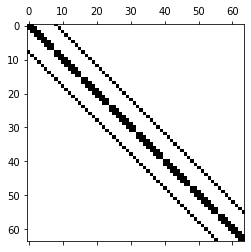

In [187]:
def exercise4():
    M = 8
    N = M * M
    A = poisson2_matrix(M)
    
    # A is symmetric
    e = np.linalg.norm(A.T - A)
    print(f'A^T - A = {e}')
    
    # A is positive definite
    v = np.random.rand(N)
    e = np.linalg.norm(v.dot(A @ v))
    print(f'v^T A v = {e}')
    
    det_A = np.linalg.det(A)
    print(f'det(A) = {det_A}')
    
    plt.spy(A)
    
    w = np.linspace(1, N, N)**2
    print(f'A w = {(A @ w).sum()}')
    
exercise4()

## Exercise 5 - Conjugate gradient method

The goal of this exercise is to implement the conjugate gradient method for solving a linear system. This method performs a k-dimensional optimization at each step k of the iteration using only linear cost, enabling it to converge to the true solution of an N dimensional system in N linear steps.

I have implemented the conjugate gradient method in the function `cg1(A, b, x, m)` below, where it takes four arguments: the coefficient matrix $A$, the righthand side vector $b$, an initial solution estimate $x$, and a maximum number of steps $m$.

In [ ]:
def cg1(A, b, x, m):
    '''
    Solve Ax = b for x using the
    conjugate gradient method.

    Args:
        A: (N, N) coefficient matrix
        b: (N, 1) righthand side vector
        x: (N, 1) initial guess vector
        m: Max number of iterations
    Returns:
        x: (N, 1) solution vector
    '''
    N, _ = A.shape
    assert A.shape == (N, N)
    assert b.shape == (N,)
    assert x.shape == (N,)
    assert m > 0

    # initial residual
    r = b - A @ x

    for k in range(m):

        # numerator of step size
        rho = r.dot(r)
        if rho == 0:
            break # found solution

        # line search direction
        if k > 0:
            # conjugate gradient
            beta = rho / rho_prev
            p = r + beta * p
        else:
            # steepest descent
            p = r
        
        # residual update direction
        q = A @ p
        
        # denominator of step size
        gamma = p.dot(q)
        if gamma <= 0:
            raise Exception('A is not positive definite')
            
        # optimal step size
        alpha = rho / gamma
        
        # update solution and residual
        x = x + alpha * p
        r = r - alpha * q
        rho_prev = rho
        
    return x

I tested the conjugate gradient method in the function below by applying it to two different linear systems of varying sizes. For each system the algorithm was performed using 10 iterations or N iterations, and the final error and resiudal are displayed.

In [218]:
def exercise5():
    for M in [5, 31]:
        N = M * M
        A = poisson2_matrix(M)
        x_true = np.random.rand(N)
        b = A @ x_true
        for m in [10, N]:
            x_pred = np.zeros(N)
            x_pred = cg1(A, b, x_pred, m)
            e = np.linalg.norm(x_true - x_pred)
            r = np.linalg.norm(b - A @ x_pred)
            print(f'M = {M}\tm = {m}\terror = {e:.8e}\tresidual = {r:.8e}')
        
exercise5()

M = 5	m = 10	error = 6.04279244e-02	residual = 1.32155407e+00
M = 5	m = 25	error = 2.01405873e-09	residual = 5.69572225e-07
M = 31	m = 10	error = 8.58697753e+00	residual = 2.42710708e+03
M = 31	m = 961	error = 1.26092049e-14	residual = 5.78817012e-11


We can see from the print out that the method converges to very low error in N steps. On a small system it can achieve acceptable error in even fewer steps, but the larger system is harder to solve for a fixed number of steps.

## Exercise 6 - Conjugate gradient with convergence test

The purpose of this exercise is to extend the conjugate gradient method with a simple test for convergence at no added computational cost per iteration. By checking the relative residual against a tolerance parameter, we can break from the algorithm early and possibly converge to an acceptable error level in fewer than $N$ iterations. I implemented this convergence test in an improved `cg2(A, b, x, tol)` function below.

In [258]:
def cg2(A, b, x, tol):
    '''
    Solve Ax = b for x using the
    conjugate gradient method.

    Args:
        A: (N, N) coefficient matrix
        b: (N, 1) righthand side vector
        x: (N, 1) initial guess vector
        tol: Tolerance parameter
    Returns:
        x: (N, 1) solution vector
        k: Number of iterations
    '''
    N, _ = A.shape
    assert A.shape == (N, N)
    assert b.shape == (N,)
    assert x.shape == (N,)
    assert tol >= 0

    # initial residual
    r = b - A @ x
    
    target = (tol * np.linalg.norm(b))**2

    for k in range(N):

        # numerator of step size
        rho = r.dot(r)
        if rho <= target:
            break # found solution

        # line search direction
        if k > 0:
            # conjugate gradient
            beta = rho / rho_prev
            p = r + beta * p
        else:
            # steepest descent
            p = r
        
        # residual update direction
        q = A @ p
        
        # denominator of step size
        gamma = p.dot(q)
        if gamma <= 0:
            raise Exception('A is not positive definite')
            
        # optimal step size
        alpha = rho / gamma
        
        # update solution and residual
        x = x + alpha * p
        r = r - alpha * q
        rho_prev = rho
        
    return x, k

I tested the conjugate gradient convergence test on a 2D Poisson problem with size $N = 31^2 = 961$ and a tolerance of 1e-5. We can see from the messages below that the method converged within just 75 iterations, which is far fewer than the theoretical maximum of 961.

In [265]:
def exercise6(M=31):
    N = M * M
    A = poisson2_matrix(M)
    x_true = np.random.rand(N)
    b = A @ x_true
    x_pred = np.zeros(N)
    x_pred, k = cg2(A, b, x_pred, tol=1e-5)
    e = np.linalg.norm(x_true - x_pred)
    r = np.linalg.norm(b - A @ x_pred)
    rr = r / np.linalg.norm(b)
    print(f'error = {e:.8e}\nresidual = {r:.8e}\nratio = {rr:.8e}\niterations = {k} / {N}')
        
exercise6()

error = 1.52750127e-03
residual = 4.49531653e-01
ratio = 9.70711334e-06
iterations = 75 / 961


## Exercise 7 - Sparse Poisson matrix

In this exercise, we will explore a way of representing the discrete Lapalacian in a more compact form where the matrix only stores 3 columns representing the non-zero diagonals. The generating function is defined below. For an $M \times M$ 2D Poisson problem, the returned matrix is size $N \times 3$, where $N = M^2$. The first column represents the main diagonal, the second is the subdiagonal (and superdiagonal, since the matrix is symmetric) and the third column represents the "far" diagonal.

In [261]:
def poisson3_matrix(M):
    N = M * M
    A = np.zeros((N, 3))
    for k in range(N):
        A[k,0] = 8 * k + 2 * M + 2
        n, s, e, w = neighbors(k, M)
        if n is not None:
            A[k,1] = -2 * k - 1
        if e is not None:
            A[k,2] = -2 * k - M
    return A

poisson3_matrix(3)

array([[  8.,  -1.,  -3.],
       [ 16.,  -3.,  -5.],
       [ 24.,   0.,  -7.],
       [ 32.,  -7.,  -9.],
       [ 40.,  -9., -11.],
       [ 48.,   0., -13.],
       [ 56., -13.,   0.],
       [ 64., -15.,   0.],
       [ 72.,   0.,   0.]])

The conjugate gradient method doesn't care about how the coefficient matrix is stored, only that we can computed matrix-vector products with it. Therefore, we can use this sparse version of the Poisson matrix in a more efficient implementation of the conjugate gradient algorithm.

To make this work, we must also implement a function that performs the desired matrix-vector multiply given a matrix stored in this sparse symmetric diagonal format. The necessary function is implemented below, along with a quick check that it performs the intended operation by comparison with a standard matrix-vector multiply.

In [262]:
def multdiag(A, x):
    N, _ = A.shape
    M = int(np.sqrt(N))
    ax = np.zeros(N)
    k = 0
    for i in range(M):
        for j in range(M):
            ax[k] = ax[k] + A[k,0] * x[k]
            n, s, e, w = neighbors(k, M)
            if n is not None:
                ax[k] += A[k,1] * x[n]
            if e is not None:
                ax[k] += A[k,2] * x[e]
            if s is not None:
                ax[k] += A[k-1,1] * x[s]
            if w is not None:
                ax[k] += A[k-M,2] * x[w]
            k += 1
    return ax

M = 5
x = np.random.rand(M*M)
A1 = poisson2_matrix(M)
A2 = poisson3_matrix(M)

np.linalg.norm(A1 @ x - multdiag(A2, x))

1.0841599276764049e-14

We can now modify the conjugate gradient method again. This time it expects a coefficient matrix stored in sparse symmetric diagonal format and uses the `multidiag(A, x)` function to perform all of the matrix-vector multiplications.

In [271]:
def cg3(A, b, x, tol):
    '''
    Solve Ax = b for x using the
    conjugate gradient method.

    Args:
        A: (N, 3) coefficient matrix, stored
            in sparse symmetric diagonal format
        b: (N, 1) righthand side vector
        x: (N, 1) initial guess vector
        tol: Tolerance parameter
    Returns:
        x: (N, 1) solution vector
        k: Number of iterations
    '''
    N, _ = A.shape
    assert A.shape == (N, 3)
    assert b.shape == (N,)
    assert x.shape == (N,)
    assert tol >= 0

    # initial residual
    r = b - multdiag(A, x)
    
    target = (tol * np.linalg.norm(b))**2

    for k in range(N):

        # numerator of step size
        rho = r.dot(r)
        if rho <= target:
            break # found solution

        # line search direction
        if k > 0:
            # conjugate gradient
            beta = rho / rho_prev
            p = r + beta * p
        else:
            # steepest descent
            p = r
        
        # residual update direction
        q = multdiag(A, p)
        
        # denominator of step size
        gamma = p.dot(q)
        if gamma <= 0:
            raise Exception('A is not positive definite')
            
        # optimal step size
        alpha = rho / gamma
        
        # update solution and residual
        x = x + alpha * p
        r = r - alpha * q
        rho_prev = rho
        
    return x, k

We can now rerun the same test as before and verify that the method solves a 2D Poisson problem with $M = 31$ to tolerance in far fewer than $N$ steps.

In [273]:
def exercise7(M=31):
    N = M * M
    A = poisson3_matrix(M)
    x_true = np.random.rand(N)
    b = multdiag(A, x_true)
    x_pred = np.zeros(N)
    x_pred, k = cg3(A, b, x_pred, tol=1e-5)
    e = np.linalg.norm(x_true - x_pred)
    r = np.linalg.norm(b - multdiag(A, x_pred))
    rr = r / np.linalg.norm(b)
    print(f'error = {e:.8e}\nresidual = {r:.8e}\nratio = {rr:.8e}\niterations = {k} / {N}')
        
exercise7()

error = 1.62387448e-03
residual = 4.58944360e-01
ratio = 9.85351148e-06
iterations = 74 / 961


## Exercise 8 - Using sparsity to solve large systems

In this exercise, we will try to solve a very large Poisson problem stored either as as standard array or as a sparse symmetric matrix. Specifically, we will rerun exercise 6 (standard storage) with $M = 400$, then rerun exercise 7 (sparse storage) with the same size.

In [274]:
exercise6(M=400)

MemoryError: Unable to allocate 191. GiB for an array with shape (160000, 160000) and data type float64

In [275]:
exercise7(M=400)

error = 1.21095355e-01
residual = 9.49155288e+02
ratio = 9.94181406e-06
iterations = 221 / 160000


We ran into a memory error when trying to create the matrix in standard storage. For $M=400$, then $N = 400^2 = 160,000$, so the Poisson matrix would require $400^4$ floating point numbers. This is around 200 GB (for 64 bit floats). In contrast, we can solve the system using the sparse storage method, which only requires $400^2 \times 3$ floating points numbers, or about 4 MB. 

## Exercise 9 - Sparse matrix storage

The objective of this exercise is to learn how to create a sparse matrix by specifying only the coordinates and values of the nonzero entries using `scipy.sparse.csc_matrix`.

In [283]:
def poisson4_matrix(M):
    from scipy.sparse import csc_matrix
    
    N = M**2
    nnz = 5 * N**2 - 4 * N
    dat = np.zeros(nnz)
    row = np.zeros(nnz)
    col = np.zeros(nnz)
    
    L = 0 # count nonzeros
    k = 0 # count equations
    
    for i in range(M):
        for j in range(M):
            
            dat[L] = 8 * k + 2 * M + 2
            row[L] = k
            col[L] = k
            L += 1
            
            n, s, e, w = neighbors(k, M)
        
            if n is not None:
                dat[L] = -2 * k - 1
                row[L] = k
                col[L] = n
                L += 1
                
            if s is not None:
                dat[L] = -2 * k + 1
                row[L] = k
                col[L] = s
                L += 1
                
            if e is not None:
                dat[L] = -2 * k - M
                row[L] = k
                col[L] = e
                L += 1
    
            if w is not None:
                dat[L] = -2 * k + M
                row[L] = k
                col[L] = w
                L += 1
            
            k += 1
            
    return csc_matrix((dat, (row, col)), shape=(N, N), dtype=np.float64)

np.linalg.norm(poisson4_matrix(3) - poisson2_matrix(3))

0.0

After verifying that the above function generates a sparse matrix that represents that same exact matrix as the full array base Poisson matrix, I can used it to store coefficient matrices for solving linear systems with the conjugate gradient method. In the function below, I made minimal modifications that enable the conjugate gradient method to handle scipy sparse matrices.

In [286]:
def cg4(A, b, x, tol):
    '''
    Solve Ax = b for x using the
    conjugate gradient method.

    Args:
        A: (N, N) coefficient matrix, stored
            as a scipy.sparse.csc_matrix
        b: (N, 1) righthand side vector
        x: (N, 1) initial guess vector
        tol: Tolerance parameter
    Returns:
        x: (N, 1) solution vector
        k: Number of iterations
    '''
    N, _ = A.shape
    assert A.shape == (N, N)
    assert b.shape == (N,)
    assert x.shape == (N,)
    assert tol >= 0

    # initial residual
    r = b - A.dot(x)
    
    target = (tol * np.linalg.norm(b))**2

    for k in range(N):

        # numerator of step size
        rho = r.dot(r)
        if rho <= target:
            break # found solution

        # line search direction
        if k > 0:
            # conjugate gradient
            beta = rho / rho_prev
            p = r + beta * p
        else:
            # steepest descent
            p = r
        
        # residual update direction
        q = A.dot(p)
        
        # denominator of step size
        gamma = p.dot(q)
        if gamma <= 0:
            raise Exception('A is not positive definite')
            
        # optimal step size
        alpha = rho / gamma
        
        # update solution and residual
        x = x + alpha * p
        r = r - alpha * q
        rho_prev = rho
        
    return x, k

Finally, we can solve a 2D model Poisson problem stored as a scipy sparse matrix with the conjugate gradient method.

In [288]:
def exercise9(M=31):
    N = M * M
    A = poisson4_matrix(M)
    x_true = np.random.rand(N)
    b = A.dot(x_true)
    x_pred = np.zeros(N)
    x_pred, k = cg4(A, b, x_pred, tol=1e-5)
    e = np.linalg.norm(x_true - x_pred)
    r = np.linalg.norm(b - A.dot(x_pred))
    rr = r / np.linalg.norm(b)
    print(f'error = {e:.8e}\nresidual = {r:.8e}\nratio = {rr:.8e}\niterations = {k} / {N}')
        
exercise9()

error = 1.65699215e-03
residual = 4.47613128e-01
ratio = 9.79640124e-06
iterations = 74 / 961


We can see from the output above that the solver converged under the tolerance limit in far fewer than $N$ iterations, as expected.